In [422]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [439]:
file_name = "full_data_with_hospital_MA_v0517.csv"
cases = pd.read_csv(file_name,index_col = 0)
cases.date = pd.to_datetime(cases.date)
cases = cases[cases.date!="2020/5/10"]
cases.set_index('date', inplace=True)
confirmed = cases.confirmed_cases != 0 
risk = cases.risk != 0
cases = cases[confirmed | risk]
cases = cases.drop_duplicates()
cases['infected_count']  = cases.confirmed_cases-cases.cum_deaths_count-cases.cum_recovered_count
cases = cases[cases.STATE == "NY"]
cases_dict = {}
for county in cases.COUNTY.unique():
    if isinstance(county, str):
        county_cases = cases[cases.COUNTY==county]
        if sum(county_cases.confirmed_cases) > 100:
            cases_dict[county] = cases[cases.COUNTY==county]



In [440]:
pop_dict = {}
for county_name in cases_dict.keys():
    if isinstance(county_name, str):
        county_cases = cases_dict[county_name]
        if sum(county_cases.confirmed_cases) > 100:
            pop_dict[county_name] = list(county_cases['Population Density'])[0]


[0.0005 0.05   0.05  ]
[0.00050001 0.05       0.05      ]
[0.0005     0.05000001 0.05      ]
[0.0005     0.05       0.05000001]
[0. 0. 0.]
[1.e-08 0.e+00 0.e+00]
[0.e+00 1.e-08 0.e+00]
[0.e+00 0.e+00 1.e-08]
[6.44179955e-06 0.00000000e+00 0.00000000e+00]
[6.45179955e-06 0.00000000e+00 0.00000000e+00]
[6.44179955e-06 1.00000000e-08 0.00000000e+00]
[6.44179955e-06 0.00000000e+00 1.00000000e-08]
[3.22089977e-05 0.00000000e+00 0.00000000e+00]
[3.22189977e-05 0.00000000e+00 0.00000000e+00]
[3.22089977e-05 1.00000000e-08 0.00000000e+00]
[3.22089977e-05 0.00000000e+00 1.00000000e-08]
[0.00013528 0.         0.        ]
[0.00013529 0.         0.        ]
[1.3527779e-04 1.0000000e-08 0.0000000e+00]
[1.3527779e-04 0.0000000e+00 1.0000000e-08]
[6.29196265e-05 0.00000000e+00 0.00000000e+00]
[6.29296265e-05 0.00000000e+00 0.00000000e+00]
[6.29196265e-05 1.00000000e-08 0.00000000e+00]
[6.29196265e-05 0.00000000e+00 1.00000000e-08]
[9.32694258e-05 0.00000000e+00 0.00000000e+00]
[9.32794258e-05 0.00000

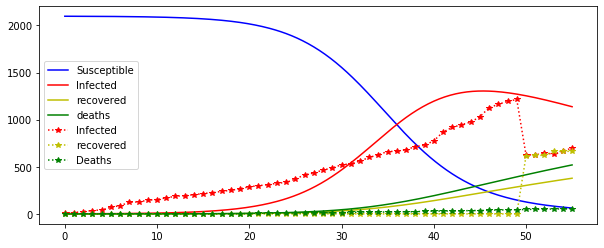

In [442]:
county_name = "ALBANY"
county_cases = cases_dict[county_name]
data = list(county_cases.infected_count)
pop = data[-1]
deaths = list(county_cases.cum_deaths_count)
recovered = list(county_cases.cum_recovered_count)
days = len(data)


def sumsq(p):
    print(p)
    if p[0] >= 1:
        return np.inf
    r, a, d = p
    def SIR(t,y):
        S = y[0]
        I = y[1]
        R = y[2]
        D = y[3]
        return([-r*S*I, r*S*I-(a+d)*I, a*I, d*I])
    sol = solve_ivp(SIR,[0,days-1],[pop*3,1,0,0],t_eval=np.arange(0,days-0.8,0.2),max_step=5)
    return(sum(((sol.y[1][::5]-data)**2)[:-20]+((sol.y[2][::5]-recovered)**2)[:-20]+((sol.y[3][::5]-deaths)**2)[:-20]))
#     return(sum(((sol.y[1][::5]-data)**2)[:-10]))

from scipy.optimize import minimize

msol = minimize(sumsq,[0.0005,0.05,0.05],bounds=((0,1),(0,1),(0,1)))
print(msol.fun)

r, a, d = msol.x
def SIR(t,y):
    S = y[0]
    I = y[1]
    R = y[2]
    D = y[3]
    return([-r*S*I, r*S*I-(a+d)*I, a*I, d*I])

sol = solve_ivp(SIR,[0,days-1],[pop*3,1,0,0],t_eval=np.arange(0,days-0.8,0.2))

fig = plt.figure(figsize=(10,4))
plt.plot(sol.t,sol.y[0],"b-")
plt.plot(sol.t,sol.y[1],"r-")
plt.plot(sol.t,sol.y[2],"y-")
plt.plot(sol.t,sol.y[3],"g-")
plt.plot(np.arange(0,days),data,"r*:")
plt.plot(np.arange(0,days),recovered, "y*:")
plt.plot(np.arange(0,days),deaths, "g*:")
plt.legend(["Susceptible","Infected","recovered","deaths","Infected","recovered","Deaths"])

In [443]:
def argmin(d):
    if not d: return None
    min_val = min(d.values())
    return [k for k in d if d[k] == min_val][0]

ALBANY


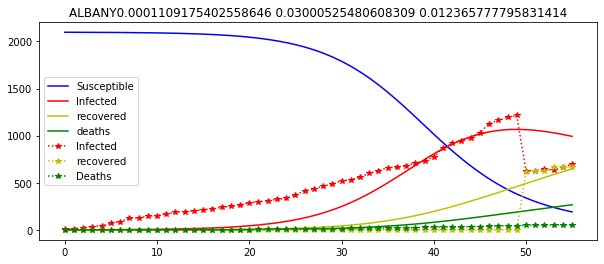

BROOME


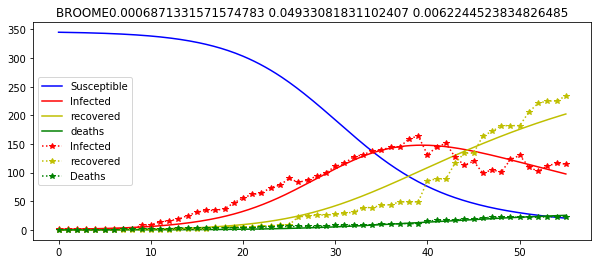

CATTARAUGUS


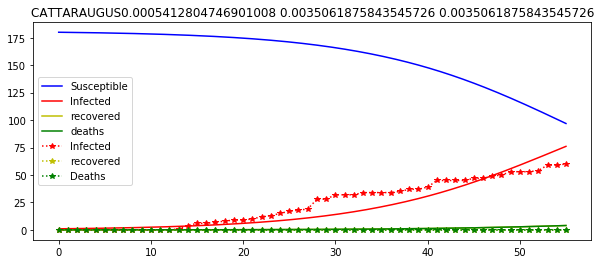

CHAUTAUQUA
CHEMUNG


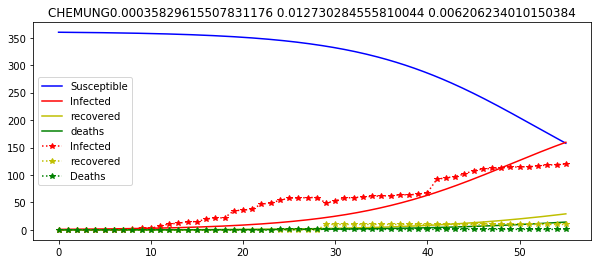

CHENANGO


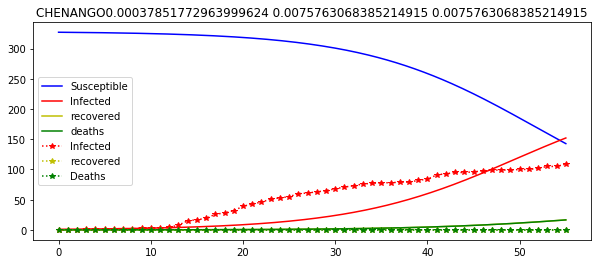

CORTLAND
DELAWARE
DUTCHESS


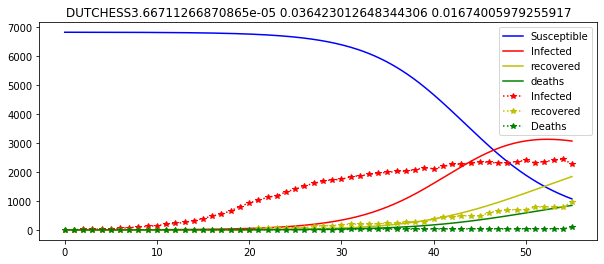

ERIE


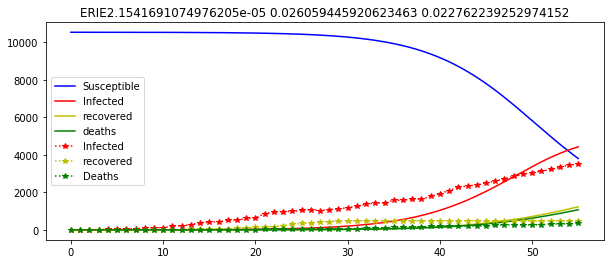

ESSEX
FRANKLIN
FULTON


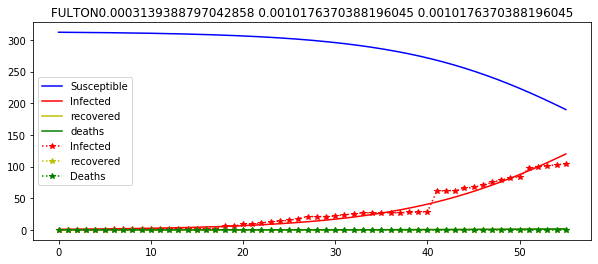

GENESEE


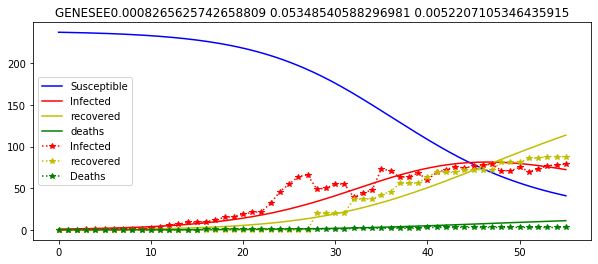

HERKIMER


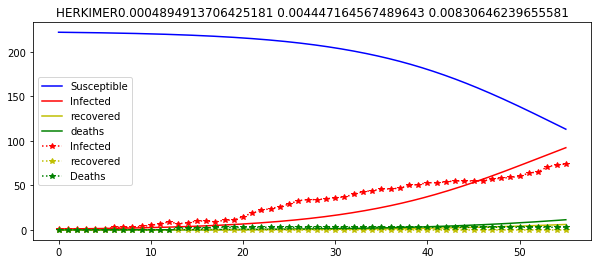

JEFFERSON


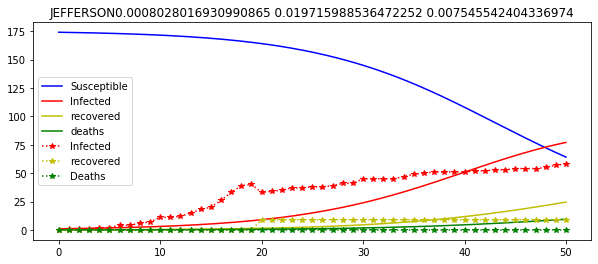

MADISON


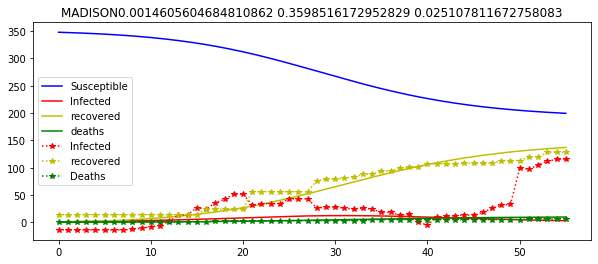

MONROE


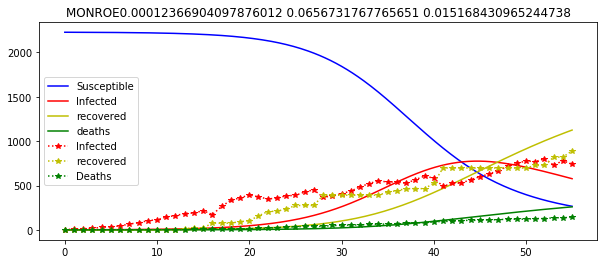

MONTGOMERY
NASSAU


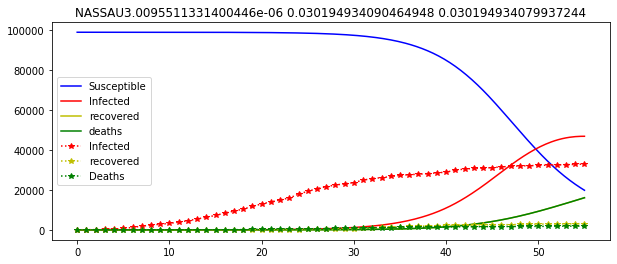

NEW YORK


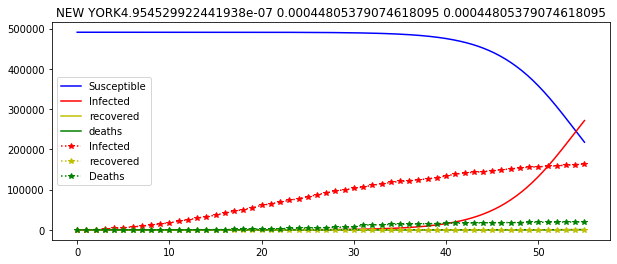

NIAGARA


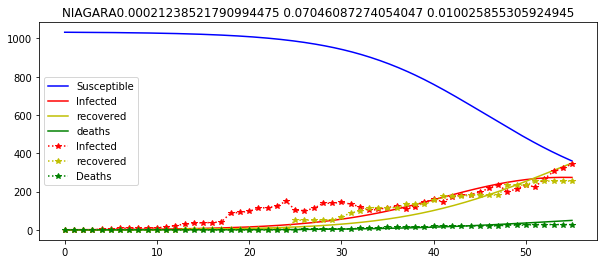

ONEIDA


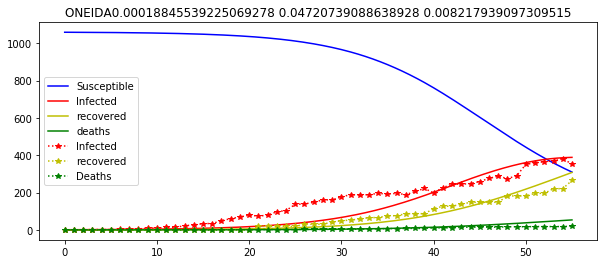

ONONDAGA


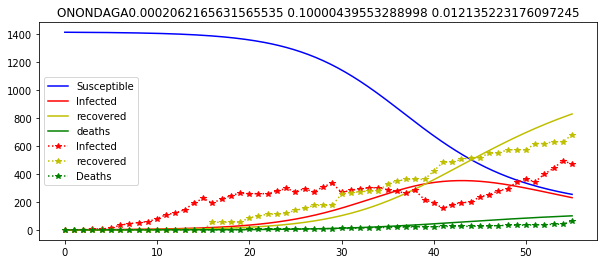

ONTARIO
ORANGE


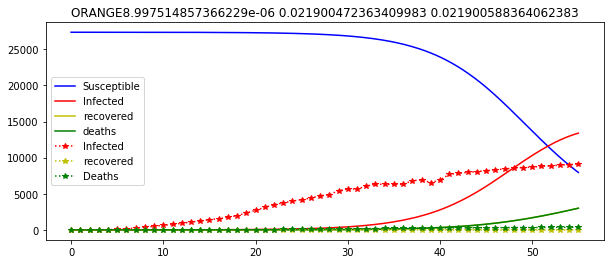

ORLEANS


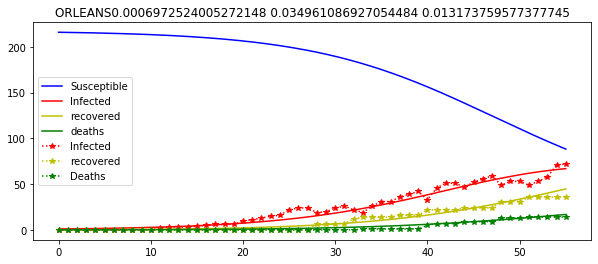

OTSEGO
PUTNAM


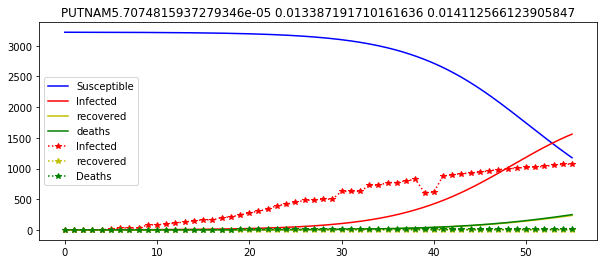

RENSSELAER


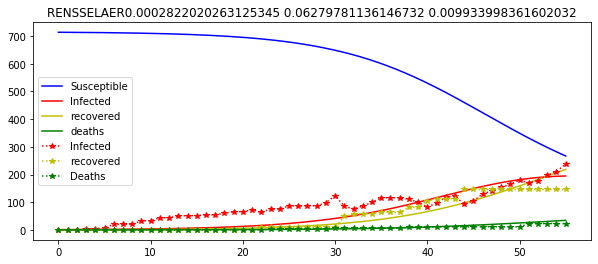

ROCKLAND


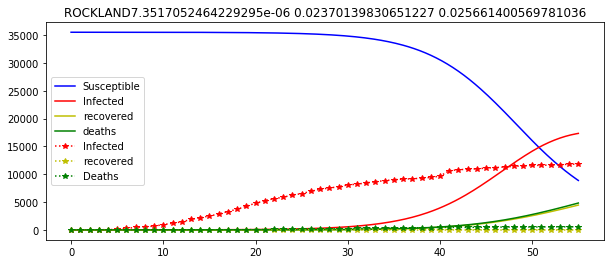

SARATOGA


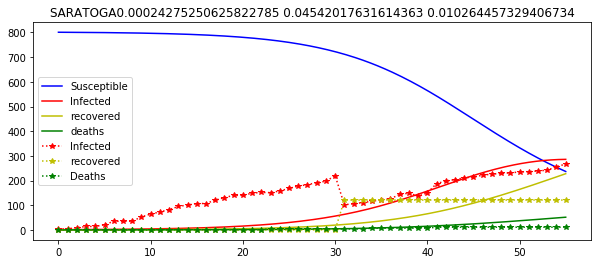

SCHENECTADY


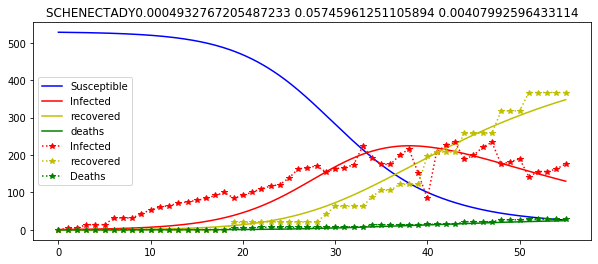

SCHOHARIE
SUFFOLK


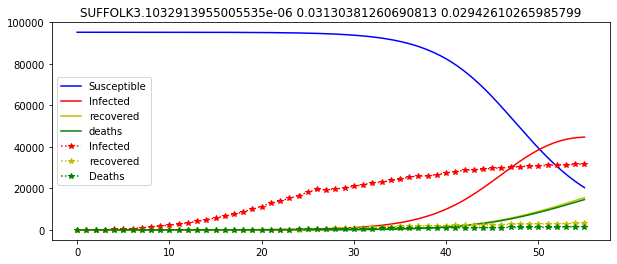

SULLIVAN


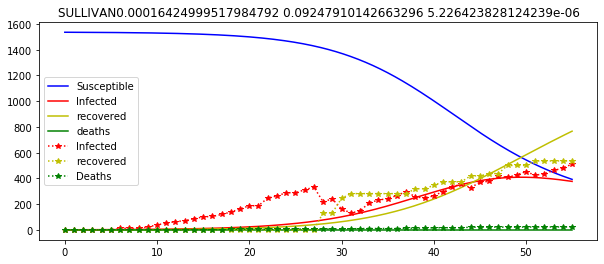

TOMPKINS
ULSTER


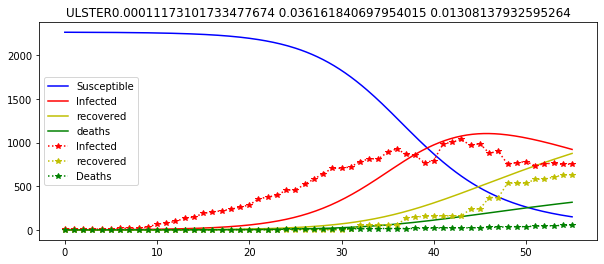

WARREN


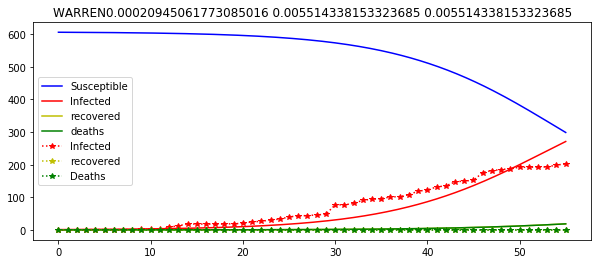

WAYNE
WESTCHESTER
WYOMING
ALLEGANY
CAYUGA
LIVINGSTON
SCHUYLER
STEUBEN


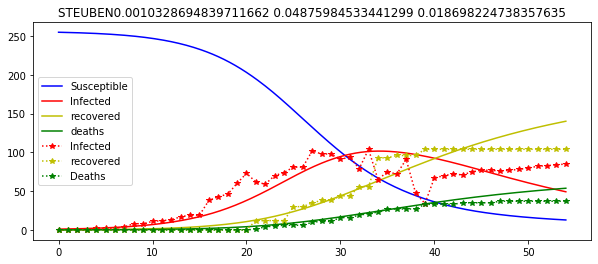

CLINTON
OSWEGO
LEWIS
YATES
ST. LAWRENCE


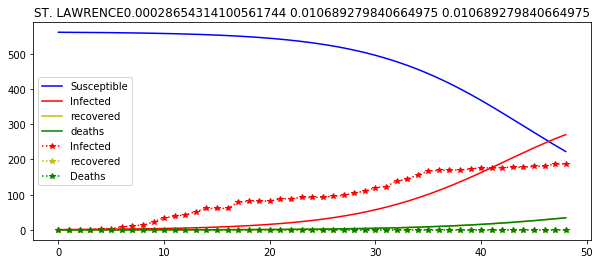

In [444]:
from scipy.optimize import minimize
y_parameters = {}
list_init = [(x,0.05,0.05) for x in [0.01,0.001,0.0001,0.00001,0.000001]]
for name, county_data in cases_dict.items():
    print(name)
    if name == "WESTCHESTER":
        continue
    data = list(county_data.infected_count)
    if data[-1] < 50:
        continue
    pop = data[-1]
    deaths = list(county_data.cum_deaths_count)
    recovered = list(county_data.cum_recovered_count)
    days = len(data)
    inti_score = {}
    for init in list_init:
        def sumsq(p):
            if p[0] >= 1:
                return np.inf
            r, a, d = p
            def SIR(t,y):
                S = y[0]
                I = y[1]
                R = y[2]
                D = y[3]
                return([-r*S*I, r*S*I-(a+d)*I, a*I, d*I])
            sol = solve_ivp(SIR,[0,days-1],[pop*3,1,0,0],t_eval=np.arange(0,days-0.8,0.2),max_step=5)
            return(sum(((sol.y[1][::5]-data)**2)+((sol.y[2][::5]-recovered)**2)+((sol.y[3][::5]-deaths)**2)))
        
        msol = minimize(sumsq,init,bounds=((0,1),(0,1),(0,1)))
        inti_score[tuple(msol.x)] = msol.fun
    
    r, a, d = argmin(inti_score)
    y_parameters[name] = (r, a, d)
    def SIR(t,y):
        S = y[0]
        I = y[1]
        R = y[2]
        D = y[3]
        return([-r*S*I, r*S*I-(a+d)*I, a*I, d*I])

    sol = solve_ivp(SIR,[0,days-1],[pop*3,1,0,0],t_eval=np.arange(0,days-0.8,0.2))

    fig = plt.figure(figsize=(10,4))
    plt.plot(sol.t,sol.y[0],"b-")
    plt.plot(sol.t,sol.y[1],"r-")
    plt.plot(sol.t,sol.y[2],"y-")
    plt.plot(sol.t,sol.y[3],"g-")
    plt.plot(np.arange(0,days),data,"r*:")
    plt.plot(np.arange(0,days),recovered, "y*:")
    plt.plot(np.arange(0,days),deaths, "g*:")
    plt.legend(["Susceptible","Infected","recovered","deaths","Infected","recovered","Deaths"])
    plt.title(name+str(r)+' '+str(a)+' '+str(d))
    plt.show()

ALBANY


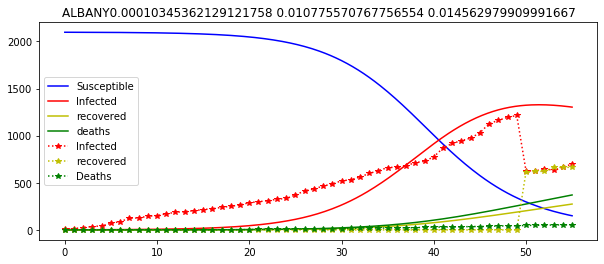

BROOME


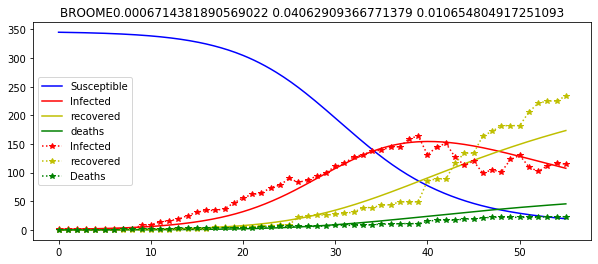

CATTARAUGUS


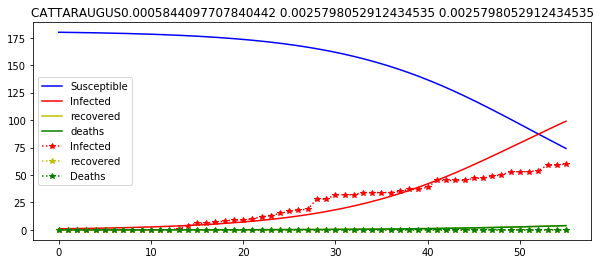

CHAUTAUQUA
CHEMUNG


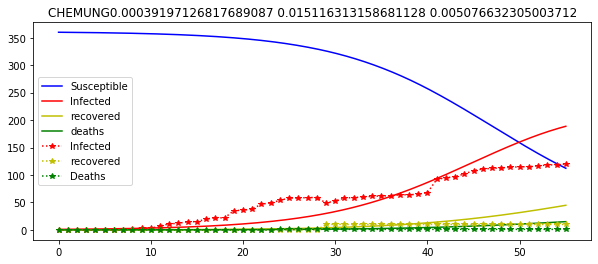

CHENANGO


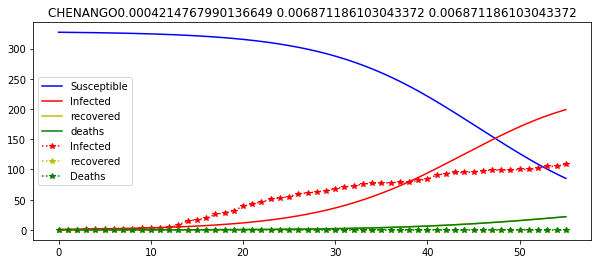

CORTLAND
DELAWARE
DUTCHESS


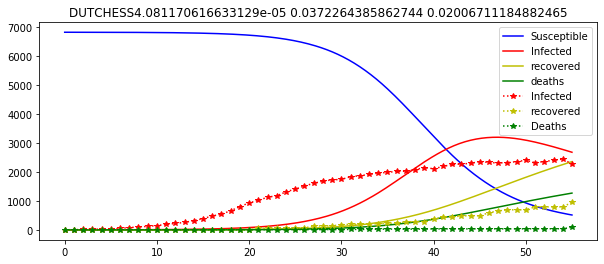

ERIE


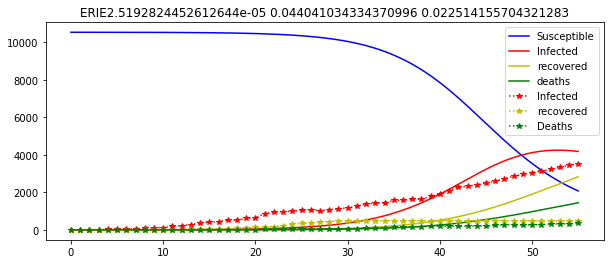

ESSEX
FRANKLIN
FULTON


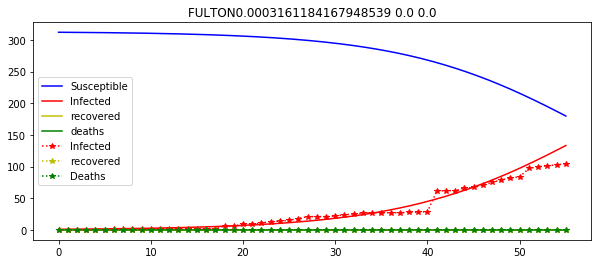

GENESEE


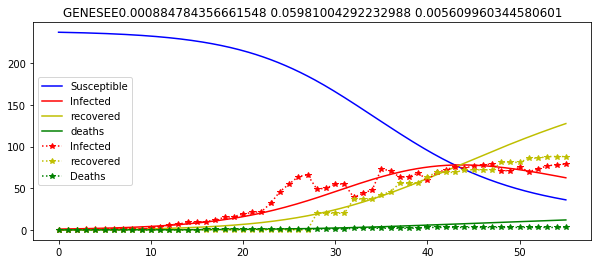

HERKIMER


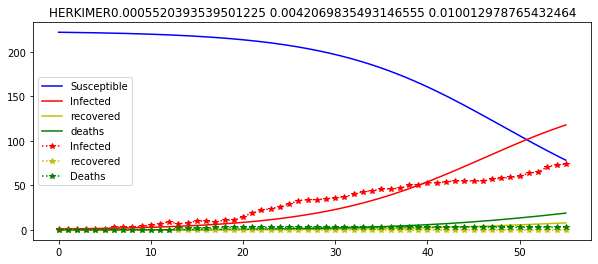

JEFFERSON


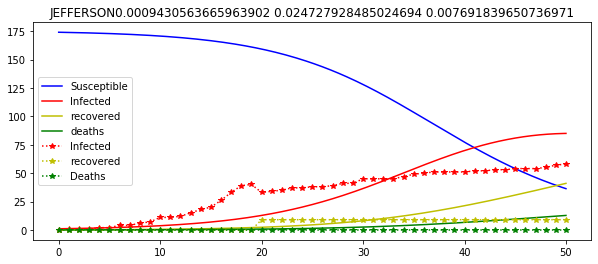

MADISON


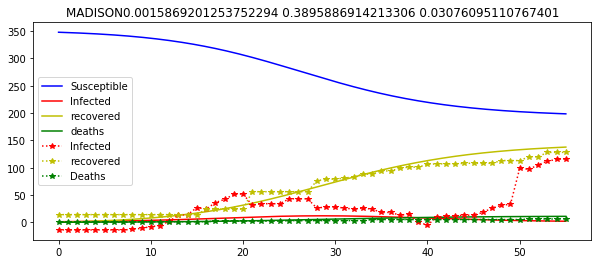

MONROE


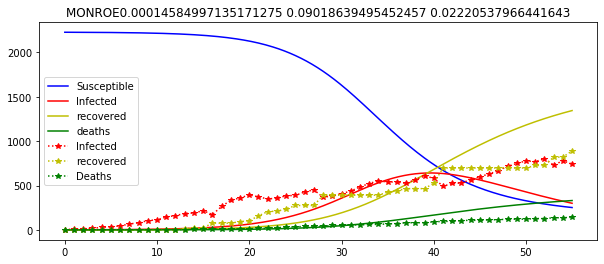

MONTGOMERY
NASSAU


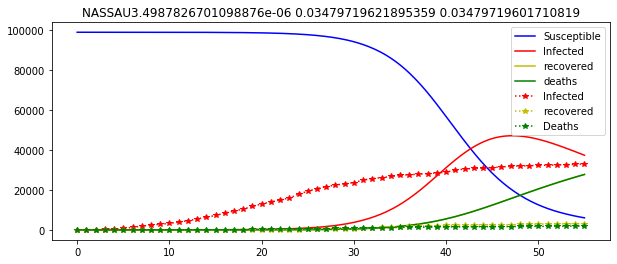

NEW YORK


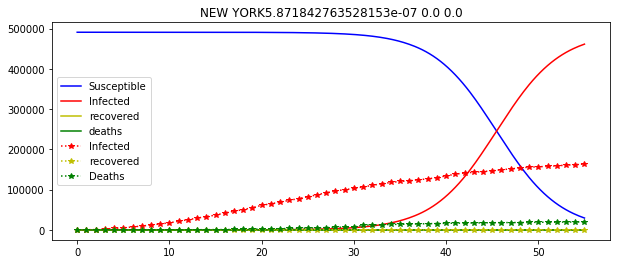

NIAGARA


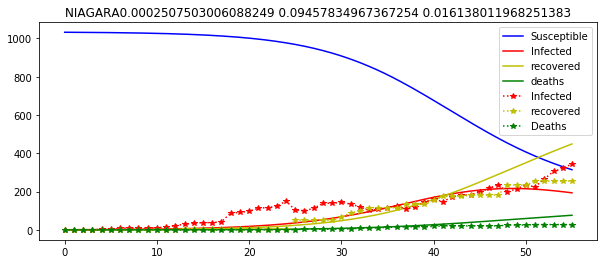

ONEIDA


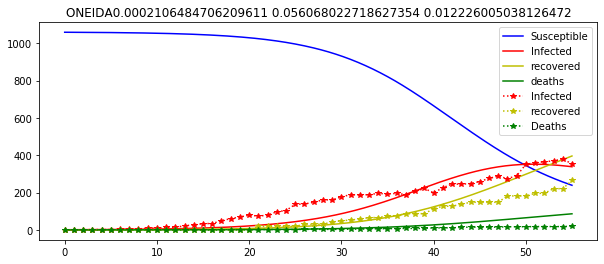

ONONDAGA


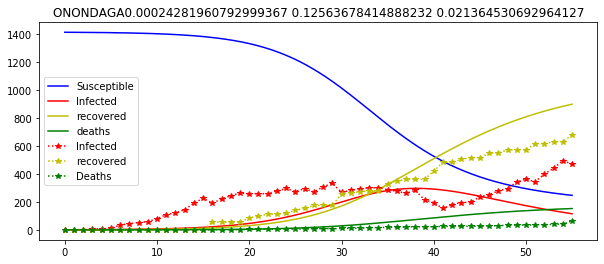

ONTARIO
ORANGE


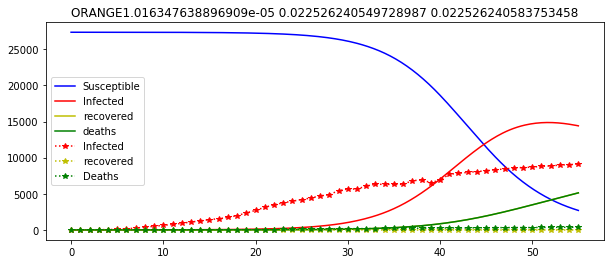

ORLEANS


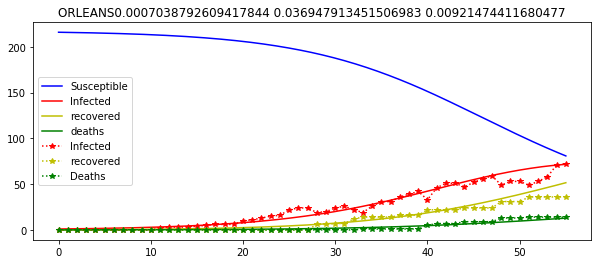

OTSEGO
PUTNAM


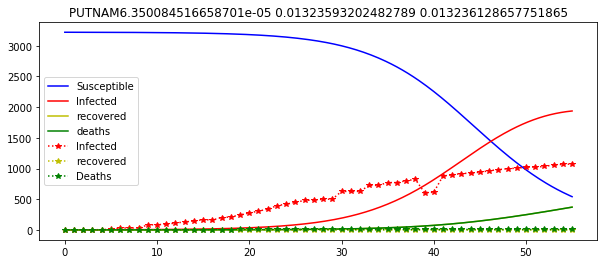

RENSSELAER


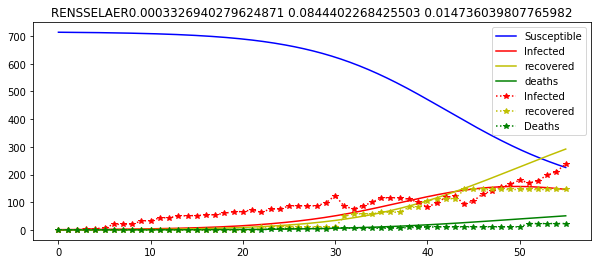

ROCKLAND


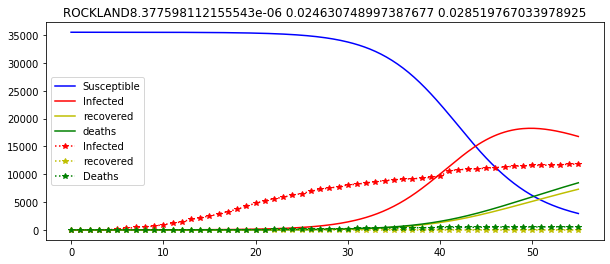

SARATOGA


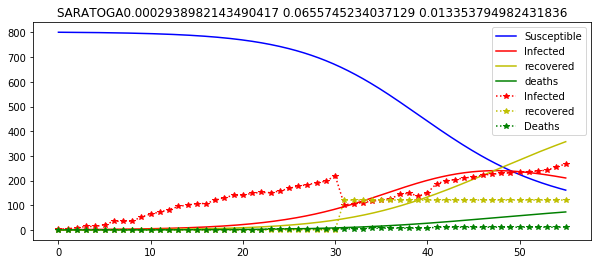

SCHENECTADY


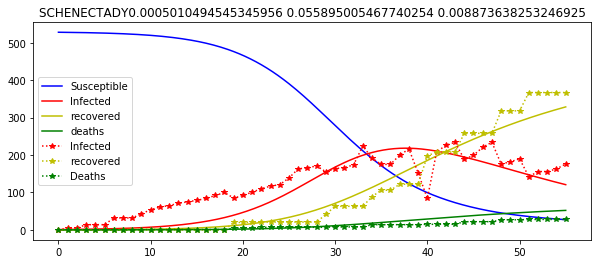

SCHOHARIE
SUFFOLK


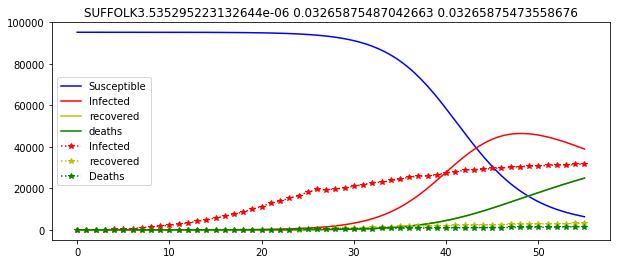

SULLIVAN


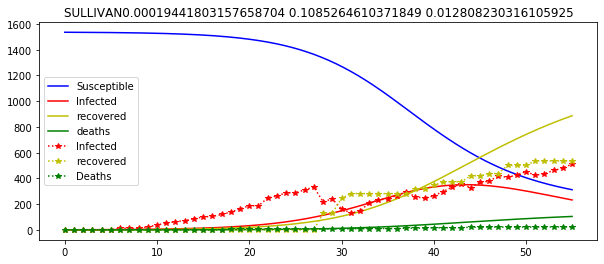

TOMPKINS
ULSTER


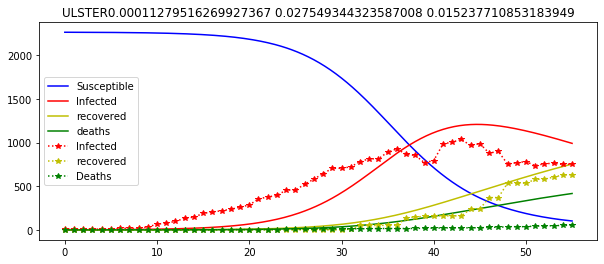

WARREN


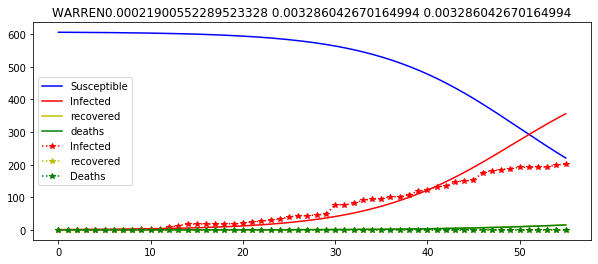

WAYNE
WESTCHESTER
WYOMING
ALLEGANY
CAYUGA
LIVINGSTON
SCHUYLER
STEUBEN


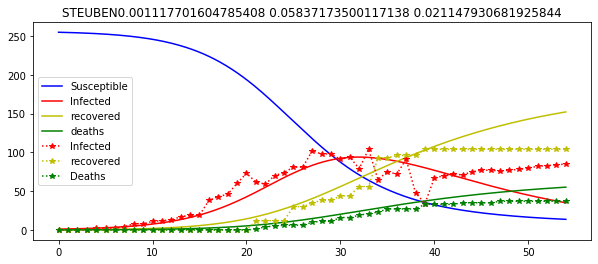

CLINTON
OSWEGO
LEWIS
YATES
ST. LAWRENCE


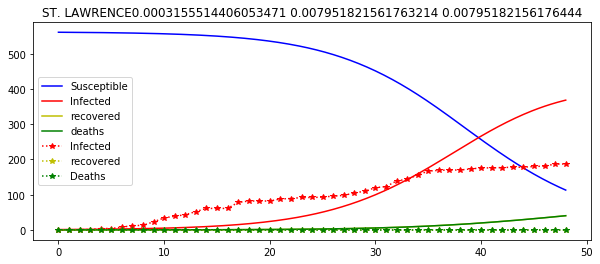

In [445]:
from scipy.optimize import minimize
x_parameters = {}
list_init = [(x,0.05,0.05) for x in [0.01,0.001,0.0005,0.0001,0.00001,0.000001]]
for name, county_data in cases_dict.items():
    print(name)
    if name == "WESTCHESTER":
        continue
    data = list(county_data.infected_count)
    if data[-1] < 50:
        continue
    pop = data[-1]
    deaths = list(county_data.cum_deaths_count)
    recovered = list(county_data.cum_recovered_count)
    days = len(data)
    inti_score = {}
    for init in list_init:
        def sumsq(p):
            if p[0] >= 1:
                return np.inf
            r, a, d = p
            def SIR(t,y):
                S = y[0]
                I = y[1]
                R = y[2]
                D = y[3]
                return([-r*S*I, r*S*I-(a+d)*I, a*I, d*I])
            sol = solve_ivp(SIR,[0,days-1],[pop*3,1,0,0],t_eval=np.arange(0,days-0.8,0.2),max_step=5)
            return(sum(((sol.y[1][::5]-data)**2)[:-10]+((sol.y[2][::5]-recovered)**2)[:-10]+((sol.y[3][::5]-deaths)**2)[:-10]))
        
        msol = minimize(sumsq,init,bounds=((0,1),(0,1),(0,1)))
        inti_score[tuple(msol.x)] = msol.fun
    
    r, a, d = argmin(inti_score)
    x_parameters[name] = (r, a, d)
    def SIR(t,y):
        S = y[0]
        I = y[1]
        R = y[2]
        D = y[3]
        return([-r*S*I, r*S*I-(a+d)*I, a*I, d*I])

    sol = solve_ivp(SIR,[0,days-1],[pop*3,1,0,0],t_eval=np.arange(0,days-0.8,0.2))
    fig = plt.figure(figsize=(10,4))
    plt.plot(sol.t,sol.y[0],"b-")
    plt.plot(sol.t,sol.y[1],"r-")
    plt.plot(sol.t,sol.y[2],"y-")
    plt.plot(sol.t,sol.y[3],"g-")
    plt.plot(np.arange(0,days),data,"r*:")
    plt.plot(np.arange(0,days),recovered, "y*:")
    plt.plot(np.arange(0,days),deaths, "g*:")
    plt.legend(["Susceptible","Infected","recovered","deaths","Infected","recovered","Deaths"])
    plt.title(name+str(r)+' '+str(a)+' '+str(d))
    plt.show()

In [446]:
set(x_parameters.keys()) == set(y_parameters.keys())

True

## use risk in ml

In [447]:
risk_x = pd.DataFrame(x_parameters).T
risk = []
for county_name in risk_x.index:
    risk.append(list(cases_dict[county_name].risk)[-11])
risk_x['risk'] = risk
risk_x = risk_x.rename(columns = {0:"x_r", 1:'x_a', 2:'x_d'})
risk_y = pd.DataFrame(y_parameters).T
risk_y = risk_y.rename(columns = {0:"true_r", 1:'true_a', 2:'true_d'})
risk_y

true_r    true_a    true_d
ALBANY        1.109175e-04  0.030005  0.012366
BROOME        6.871332e-04  0.049331  0.006224
CATTARAUGUS   5.412805e-04  0.003506  0.003506
CHEMUNG       3.582962e-04  0.012730  0.006206
CHENANGO      3.785177e-04  0.007576  0.007576
DUTCHESS      3.667113e-05  0.036423  0.016740
ERIE          2.154169e-05  0.026059  0.022762
FULTON        3.139389e-04  0.001018  0.001018
GENESEE       8.265626e-04  0.053485  0.005221
HERKIMER      4.894914e-04  0.004447  0.008306
JEFFERSON     8.028017e-04  0.019716  0.007546
MADISON       1.460560e-03  0.359852  0.025108
MONROE        1.236690e-04  0.065673  0.015168
NASSAU        3.009551e-06  0.030195  0.030195
NEW YORK      4.954530e-07  0.000448  0.000448
NIAGARA       2.123852e-04  0.070461  0.010026
ONEIDA        1.884554e-04  0.047207  0.008218
ONONDAGA      2.062166e-04  0.100004  0.012135
ORANGE        8.997515e-06  0.021900  0.021901
ORLEANS       6.972524e-04  0.034961  0.013174
PUTNAM        5.707482e-05  0.013387  0.014113
RENSSELAER    2.822020e-04  0.062798  0.009934
ROCKLAND      7.351705e-06  0.023701  0.025661
SARATOGA      2.427525e-04  0.045420  0.010264
SCHENECTADY   4.932767e-04  0.057460  0.004080
SUFFOLK       3.103291e-06  0.031304  0.029426
SULLIVAN      1.642500e-04  0.092479  0.000005
ULSTER        1.117310e-04  0.036162  0.013081
WARREN        2.094506e-04  0.005514  0.005514
STEUBEN       1.032869e-03  0.048760  0.018698
ST. LAWRENCE  2.865431e-04  0.010689  0.010689

In [448]:
# from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
model = LinearRegression()
# fit model
model.fit(risk_x, risk_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [450]:
yhat = model.predict(risk_x)
yhat = pd.DataFrame(yhat, index = risk_x.index)
yhat = yhat.rename(columns = {0:"predicted_r", 1:'predicted_a', 2:'predicted_d'})
yhat

predicted_r  predicted_a  predicted_d
ALBANY           0.000094     0.007374     0.012369
BROOME           0.000622     0.038367     0.010140
CATTARAUGUS      0.000544     0.004734     0.003481
CHEMUNG          0.000364     0.013920     0.004544
CHENANGO         0.000391     0.006912     0.006651
DUTCHESS         0.000035     0.030813     0.016596
ERIE             0.000018     0.035575     0.018382
FULTON           0.000294     0.000310    -0.000035
GENESEE          0.000820     0.057028     0.005643
HERKIMER         0.000512     0.005555     0.010270
JEFFERSON        0.000876     0.026911     0.009098
MADISON          0.001453     0.348906     0.020724
MONROE           0.000128     0.076507     0.016933
NASSAU           0.000002     0.032108     0.031327
NEW YORK         0.000006     0.003849    -0.000053
NIAGARA          0.000227     0.081496     0.011538
ONEIDA           0.000192     0.047766     0.009034
ONONDAGA         0.000217     0.108093     0.015289
ORANGE           0.000006     0.017636     0.019289
ORLEANS          0.000652     0.035435     0.009044
PUTNAM           0.000057     0.009710     0.010964
RENSSELAER       0.000303     0.073308     0.010911
ROCKLAND         0.000005     0.020477     0.025124
SARATOGA         0.000269     0.056624     0.010109
SCHENECTADY      0.000463     0.050246     0.007169
SUFFOLK          0.000002     0.030469     0.029421
SULLIVAN         0.000174     0.093772     0.007770
ULSTER           0.000102     0.022417     0.012539
WARREN           0.000203     0.002176     0.002506
STEUBEN          0.001035     0.057171     0.021346
ST. LAWRENCE     0.000292     0.007012     0.007187

In [466]:
def addloss(mydf):
    losses = []
    for county_name in mydf.index:
        print(county_name)
        county_cases = cases_dict[county_name]
        data = list(county_cases.infected_count)
        pop = data[-1]
        deaths = list(county_cases.cum_deaths_count)
        recovered = list(county_cases.cum_recovered_count)
        days = len(data)
        
        r = mydf.loc[county_name][0]
        a = mydf.loc[county_name][1]
        d = mydf.loc[county_name][2]
        
        def SIR(t,y):
            S = y[0]
            I = y[1]
            R = y[2]
            D = y[3]
            return([-r*S*I, r*S*I-(a+d)*I, a*I, d*I])
    
        sol = solve_ivp(SIR,[0,days-1],[pop*3,1,0,0],t_eval=np.arange(0,days-0.8,0.2))
        
        loss = np.mean((sol.y[1][-10:]-data[-10:])**2)
        losses.append(loss)
        fig = plt.figure(figsize=(10,4))
        plt.plot(sol.t,sol.y[0],"b-")
        plt.plot(sol.t,sol.y[1],"r-")
        plt.plot(sol.t,sol.y[2],"y-")
        plt.plot(sol.t,sol.y[3],"g-")
        plt.plot(np.arange(0,days),data,"r*:")
        plt.plot(np.arange(0,days),recovered, "y*:")
        plt.plot(np.arange(0,days),deaths, "g*:")
        plt.legend(["Predict_Susceptible","Predict_Infected","Predict_Recovered","Predict_Deaths","True_Infected","True_Recovered","True_Deaths"])
        plt.ylabel('number of cases')
        plt.xlabel('Days')
        plt.title(county_name)
        plt.savefig(fname='NewYork.png')
        plt.plot()
    mydf[mydf.columns[0][0]+'loss'] = losses
        


ALBANY
BROOME
CATTARAUGUS
CHEMUNG
CHENANGO
DUTCHESS
ERIE
FULTON
GENESEE
HERKIMER
JEFFERSON
MADISON
MONROE
NASSAU
NEW YORK
NIAGARA
ONEIDA
ONONDAGA
ORANGE
ORLEANS
PUTNAM
RENSSELAER


/Users/jiangduo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/jiangduo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ROCKLAND
SARATOGA


/Users/jiangduo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/jiangduo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


SCHENECTADY
SUFFOLK


/Users/jiangduo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/jiangduo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


SULLIVAN
ULSTER


/Users/jiangduo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/jiangduo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


WARREN
STEUBEN


/Users/jiangduo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/jiangduo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ST. LAWRENCE


/Users/jiangduo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


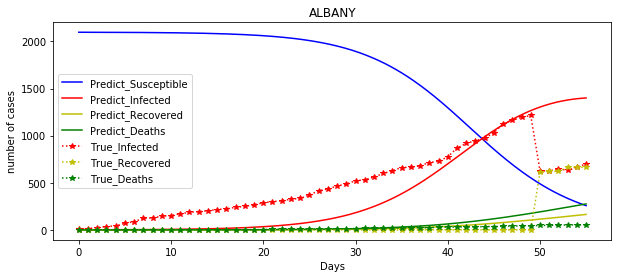

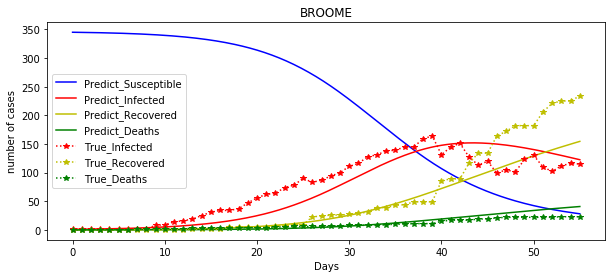

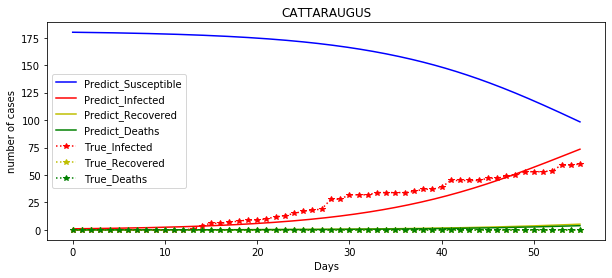

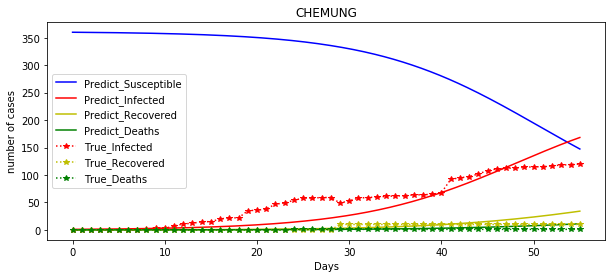

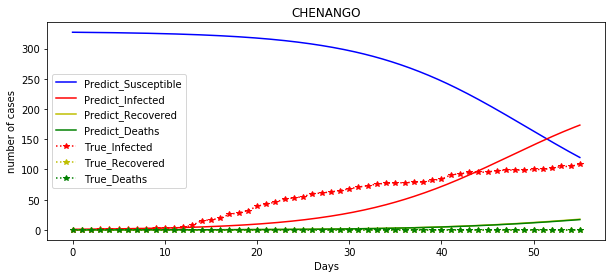

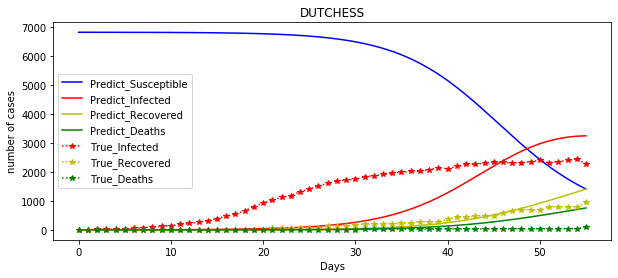

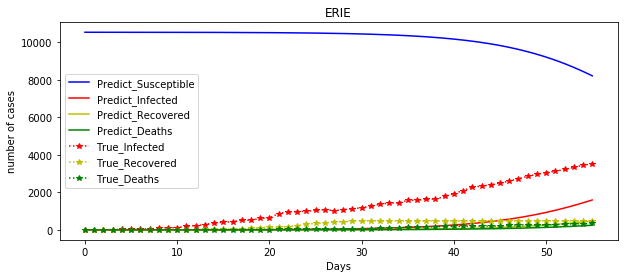

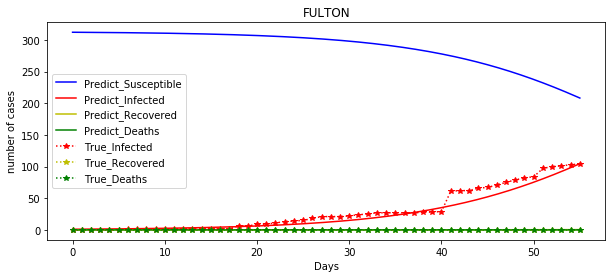

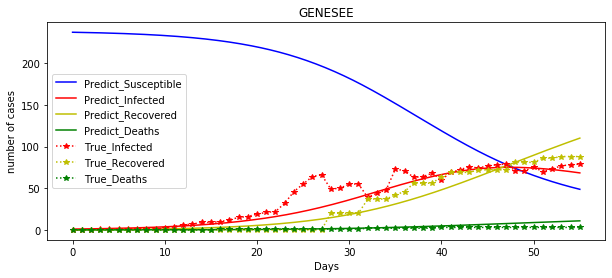

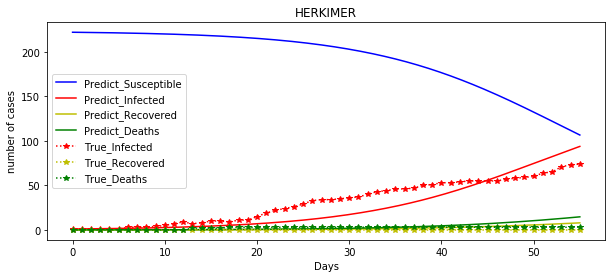

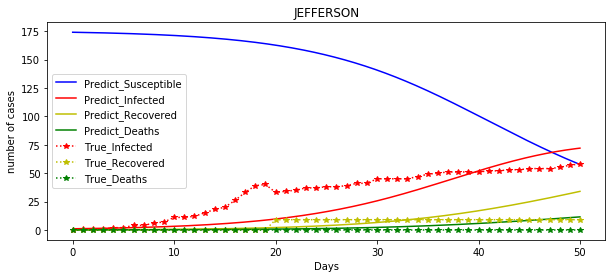

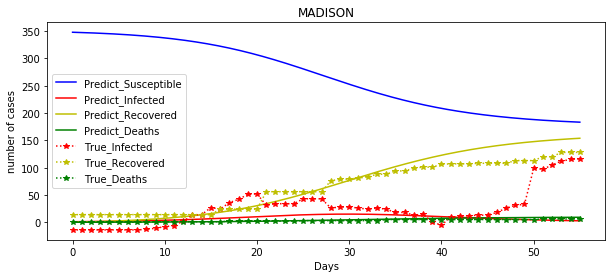

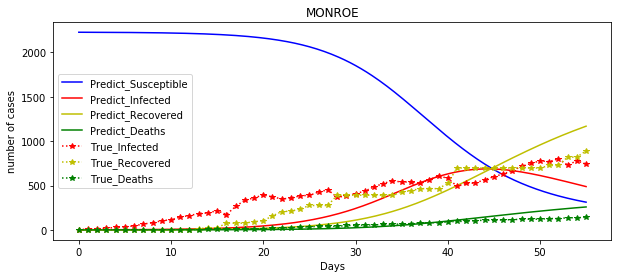

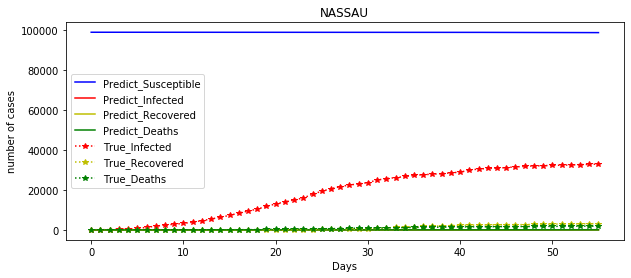

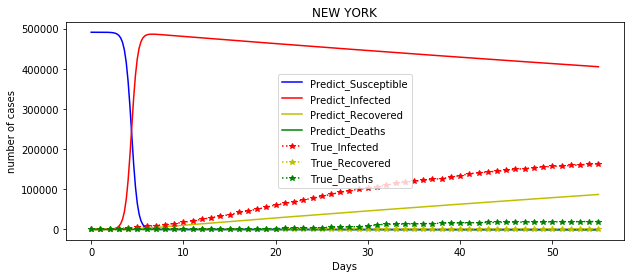

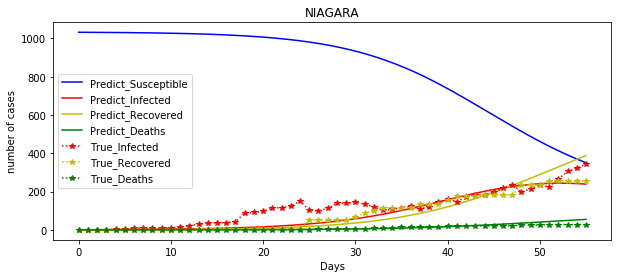

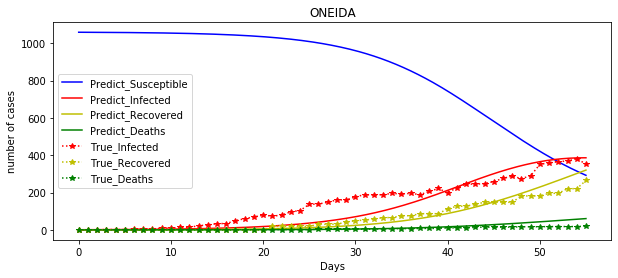

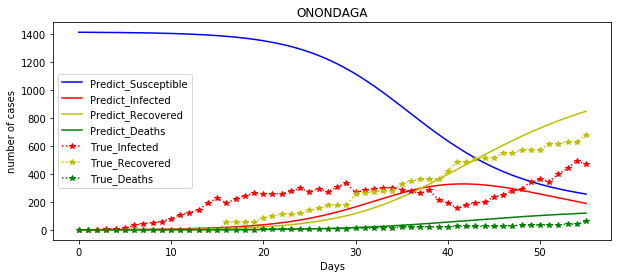

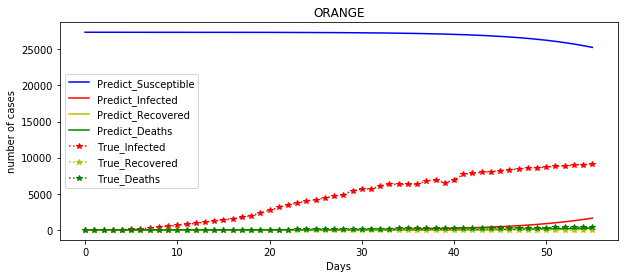

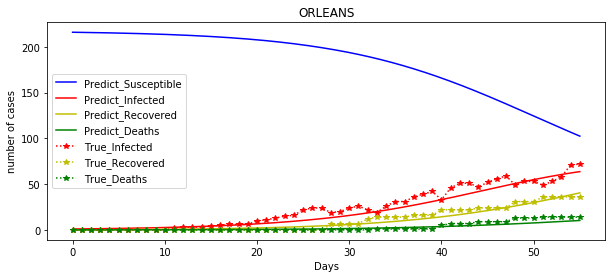

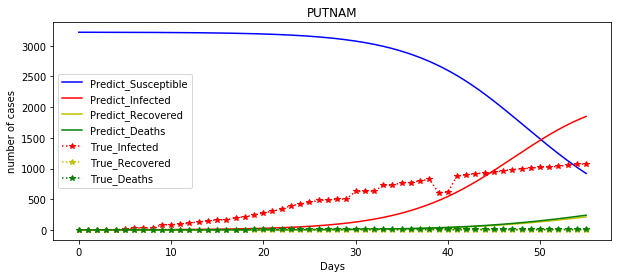

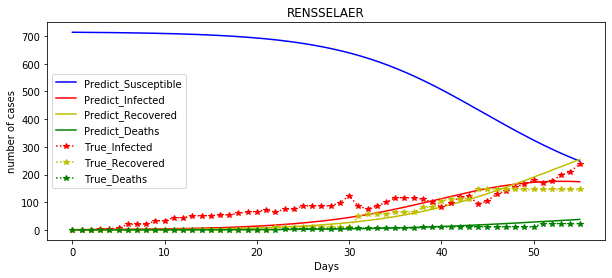

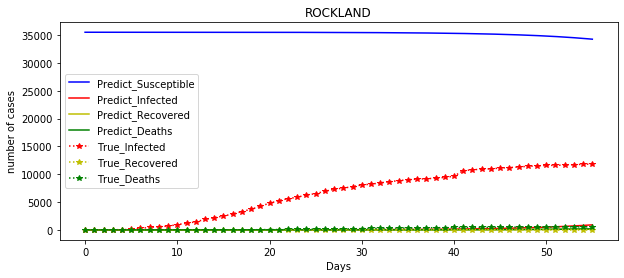

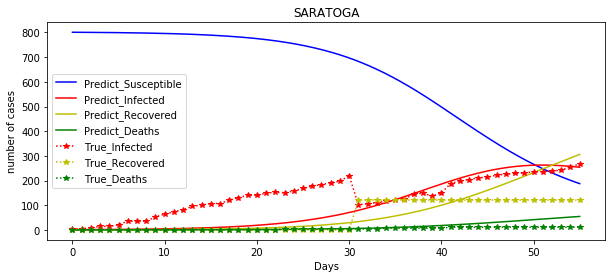

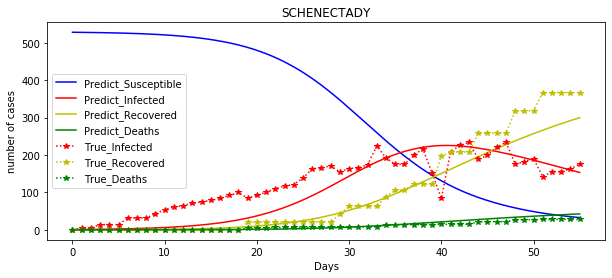

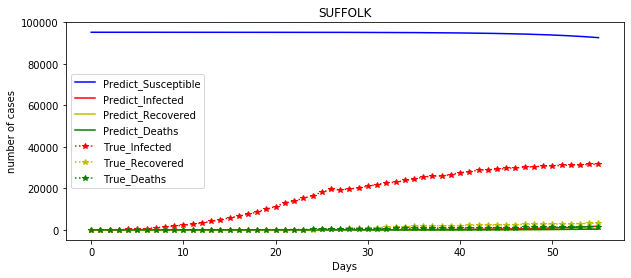

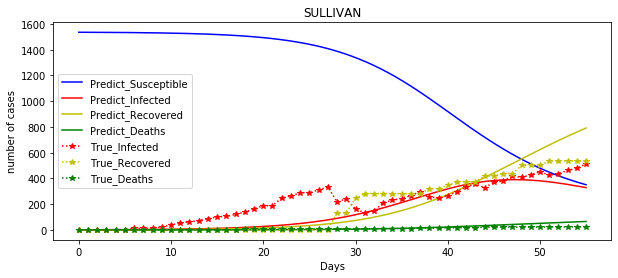

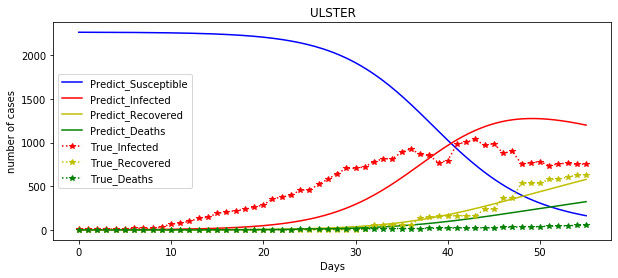

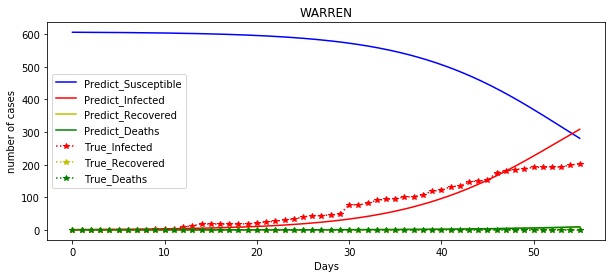

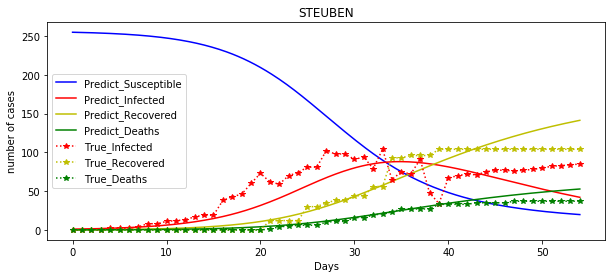

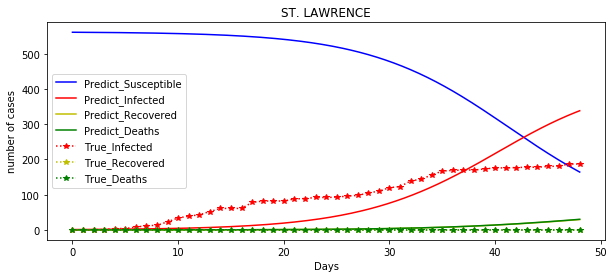

In [467]:
addloss(yhat)

ALBANY
BROOME
CATTARAUGUS
CHEMUNG
CHENANGO
DUTCHESS
ERIE
FULTON
GENESEE
HERKIMER
JEFFERSON
MADISON
MONROE
NASSAU
NEW YORK
NIAGARA
ONEIDA
ONONDAGA
ORANGE
ORLEANS
PUTNAM
RENSSELAER


/Users/jiangduo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/jiangduo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ROCKLAND
SARATOGA


/Users/jiangduo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/jiangduo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


SCHENECTADY
SUFFOLK


/Users/jiangduo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/jiangduo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


SULLIVAN
ULSTER


/Users/jiangduo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/jiangduo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


WARREN
STEUBEN


/Users/jiangduo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/jiangduo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ST. LAWRENCE


/Users/jiangduo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


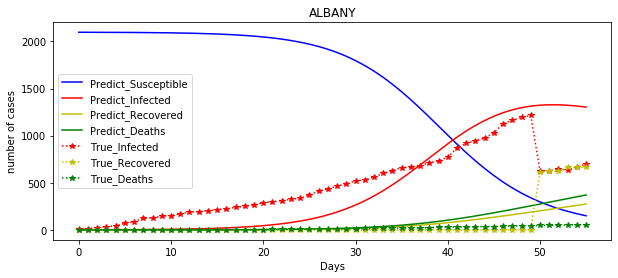

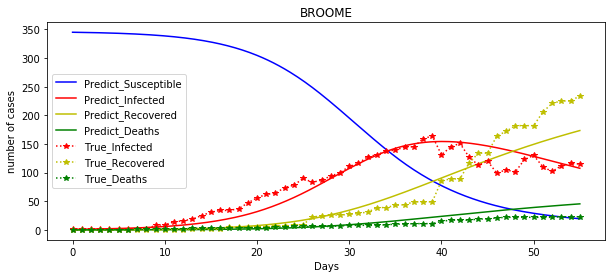

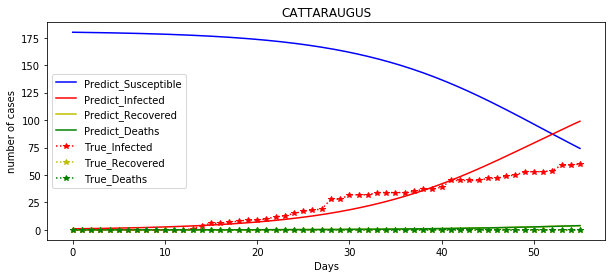

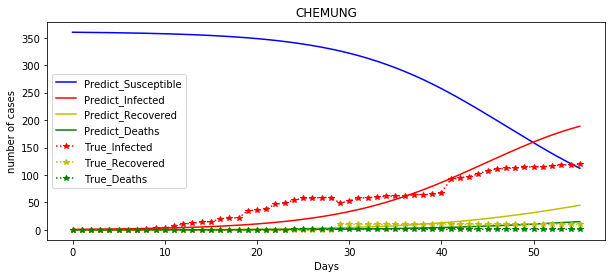

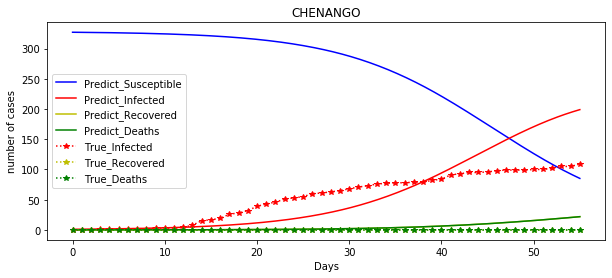

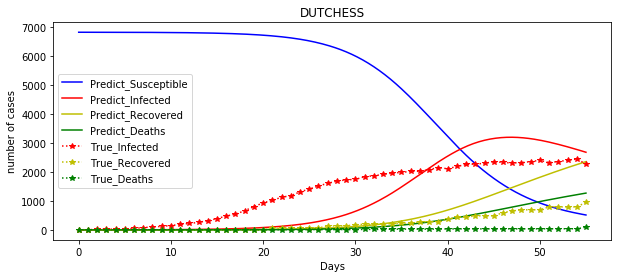

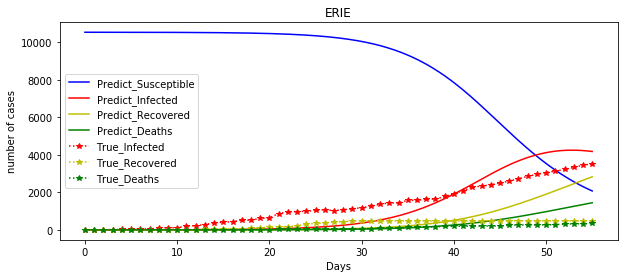

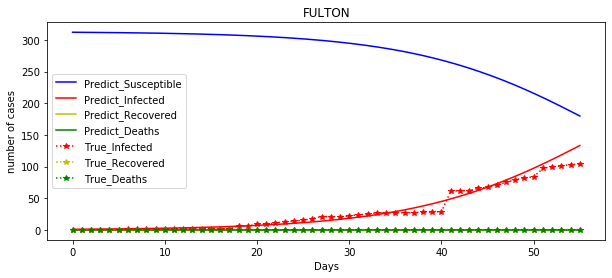

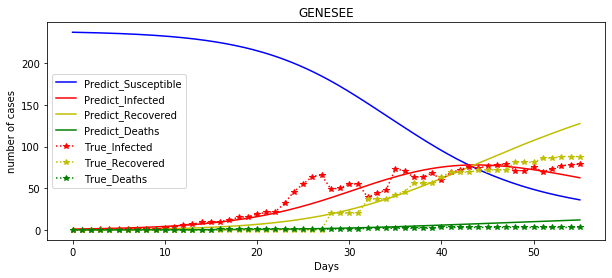

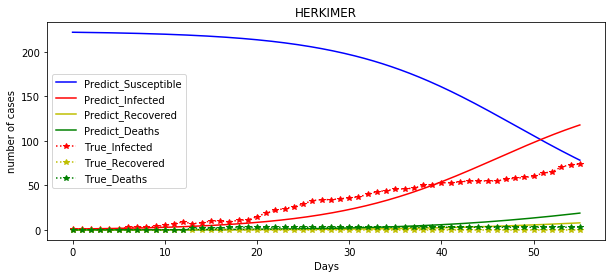

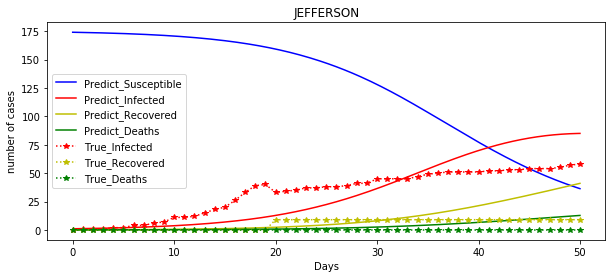

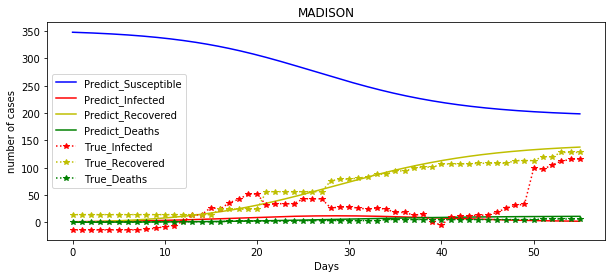

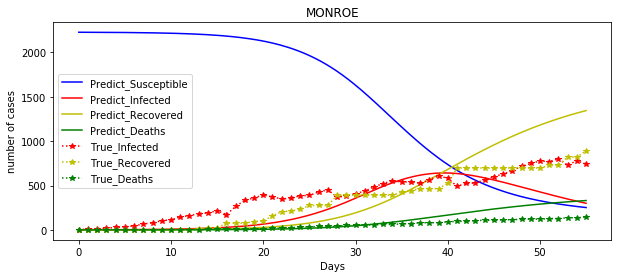

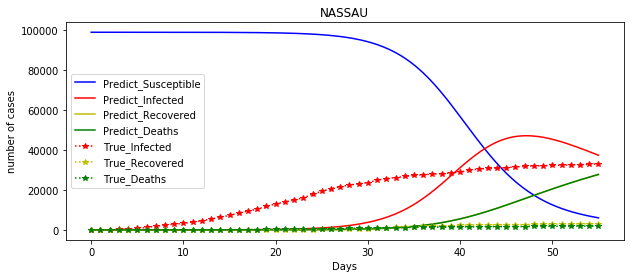

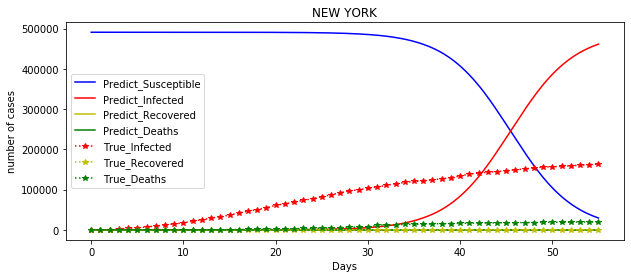

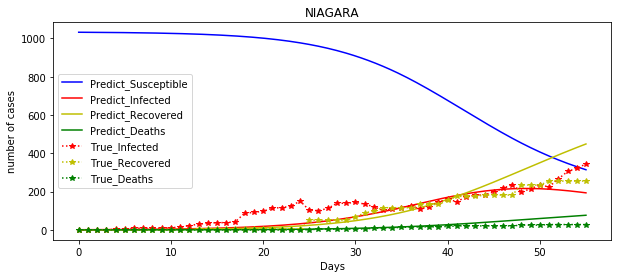

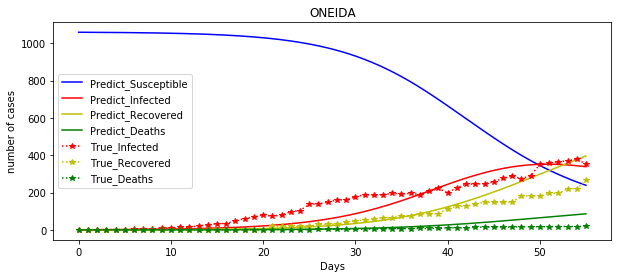

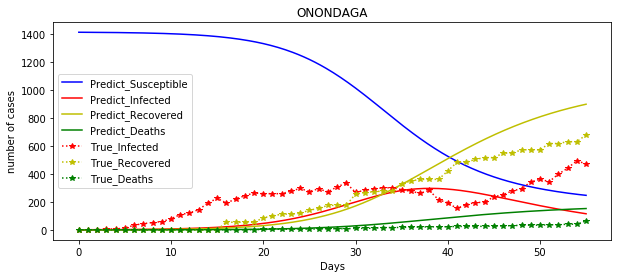

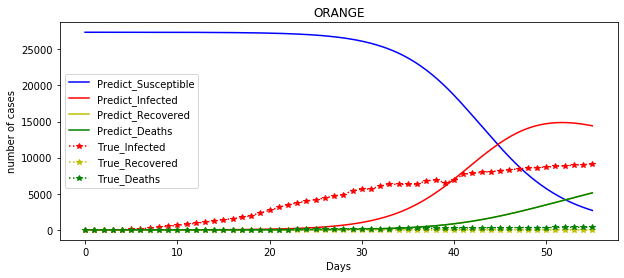

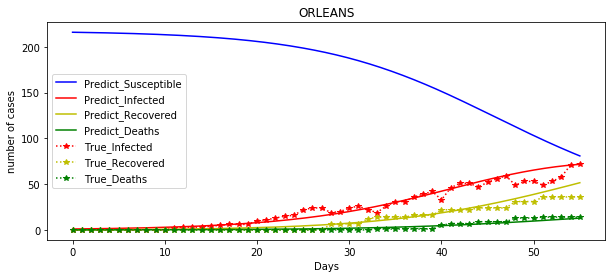

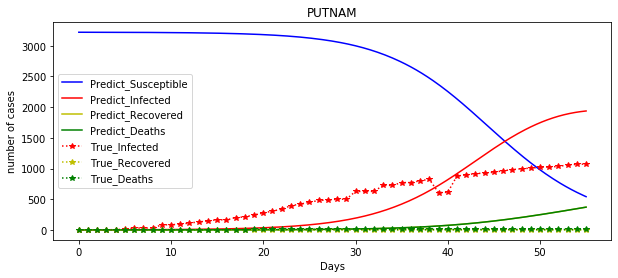

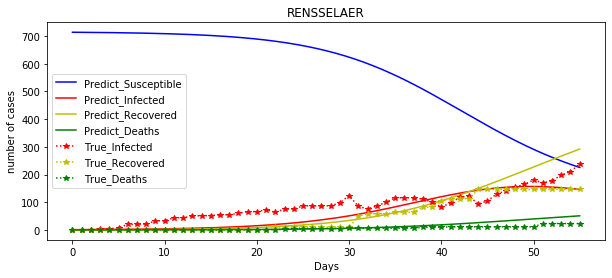

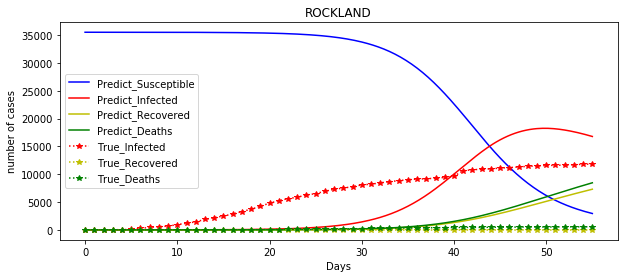

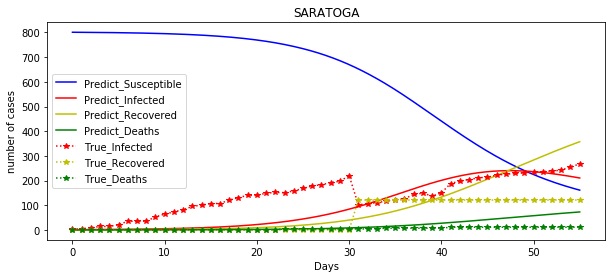

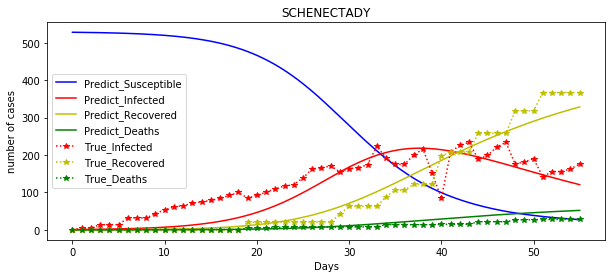

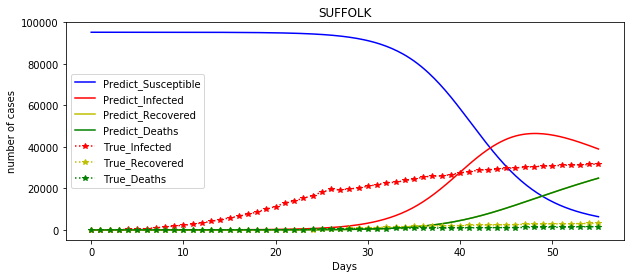

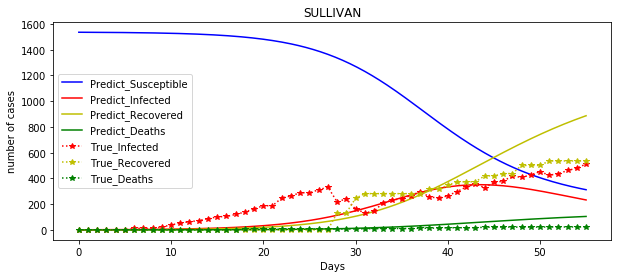

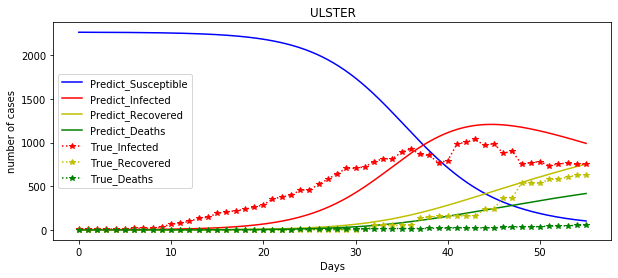

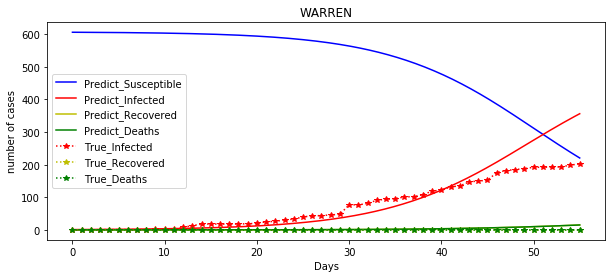

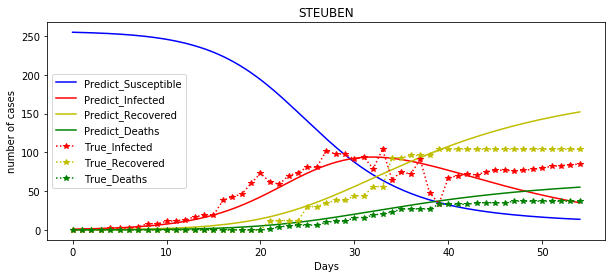

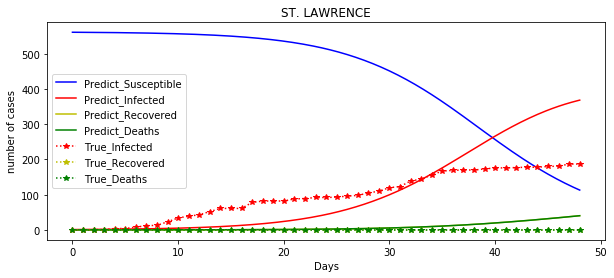

In [468]:

addloss(risk_x)

In [455]:
result = pd.concat([yhat, risk_x, risk_y], axis=1)
print(result.xloss > result.ploss)
result.to_csv('SIRD_loss.csv')

AttributeError: 'DataFrame' object has no attribute 'xloss'